In [ ]:
import numpy as np      
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
from matplotlib import rcParams
import matplotlib.dates as md
import matplotlib.colors as colors
import os
import glob
from scipy import io
import matplotlib
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings("ignore")

In [13]:
# Lidar depol ratio

dloc = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/ingested/'
start = dt.datetime(2019,7,10)
stop = dt.datetime(2019,7,12)
all_files = []
datetimes=[]
flatten = lambda l: [item for sublist in l for item in sublist]
f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')

for date in f_date_list:
    try:
        all_files.append(glob.glob( dloc+ 'smtmplpolX1.a1.%s*.cdf'%(dt.datetime.strftime(date,'%Y%m%d'))))
    except:
        print('No file for %s'%str(date))
        continue        
all_files.sort()
all_files=flatten(all_files)

times=[]
lidar_heights=[]
bs1=[]
bs2=[]
missing_times=[]

# backscatter 1 
for fil in all_files:
    temp = Dataset(fil)
    base_time = pd.to_datetime(temp.variables['base_time'][:],origin='unix',unit='s')
    temp_times = pd.to_datetime(temp.variables['time_offset'][:],origin=base_time.to_pydatetime(),unit='s')
    if np.shape(temp.variables['backscatter_1'][:,:])[1]==1200:
        times.append(temp_times.to_pydatetime()) 
        bs1.append(temp.variables['backscatter_1'][:,201:])
        bs2.append(temp.variables['backscatter_2'][:,201:])
    else:
        missing_times.append(temp_times.to_pydatetime())
    
lidar_heights = Dataset(fil).variables['height'][:]   # units: km AGL
times = np.asarray(flatten(times))

bs1 = flatten(bs1) 
bs2 = flatten(bs2) 

# Apply range squared correction, overlap correction and remove background. 
#idl code: 
#This overlap correction was a simple estimation using real background
#subtracted, range corrected data and assuming a linear trend from 
#2.4 km to the surface using data at 1800 on 31 Jan 2011 at Summit
ocorr = [0.00530759, 0.0583835, 0.110524, 0.174668, 0.246036, 0.333440, 0.421466,0.510560, 0.599191, 0.676644, 0.744512, 0.808004, 0.848976,0.890453, 0.959738, 0.975302, 1.0, 1.0]
oht = [0.0149896, 0.164886, 0.314782, 0.464678, 0.614575, 0.764471, 0.914367,1.06426, 1.21416, 1.36406, 1.51395, 1.66385, 1.81374, 1.96364,2.11354, 2.26343, 2.5, 20]
#olap = interpol(ocorr, oht, ht)
from scipy import interpolate
interpfunc = interpolate.interp1d(oht,ocorr,kind='linear')
olap = interpfunc(np.asarray(lidar_heights[201:]))

# Background? = average over heights 
# Note flynn 2020 use highest 7 km. -. 
bk1 = np.max(np.asarray(bs1)[:,750:],axis=1)
bk2 = np.max(np.asarray(bs2)[:,750:],axis=1)
#bk1 = np.mean(np.asarray(bs1)[:,750:],axis=1)
#bk2 = np.mean(np.asarray(bs2)[:,750:],axis=1)

sig1 = np.asarray(bs1)
sig2 = np.asarray(bs2)
sig1 = np.ma.masked_where(sig1<0.6,sig1)
sig2 = np.ma.masked_where(sig2<0.6,sig2)

for i in range(0,len(bs1)):
    # Background and range squared
    sig1[i,:]=(sig1[i,:] - bk1[i]) * lidar_heights[201:] * lidar_heights[201:]
    sig2[i,:]=(sig2[i,:] - bk2[i]) * lidar_heights[201:] * lidar_heights[201:]
    # Overlap correction
    sig1[i,:] = sig1[i,:] / olap
    sig2[i,:] = sig2[i,:] / olap

    
d = sig1 / (sig1 + sig2)

base = dt.datetime(times[0].year,times[0].month,times[0].day,times[0].hour)
numhours =(dt.datetime(times[-1].year,times[-1].month,times[-1].day,times[-1].hour) - base).days*24 + (dt.datetime(times[-1].year,times[-1].month,times[-1].day,times[-1].hour) - base).seconds / 60/60
date_list = set([base + dt.timedelta(hours=x) for x in range(int(numhours))])
mintimes = set([dt.datetime(t.year,t.month,t.day,t.hour) for t in times])
missing = list(set(date_list - mintimes))
missing.sort()

import matplotlib.dates as mdates
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
cmap = matplotlib.cm.get_cmap("viridis").copy()
cmap.set_bad(color='white')
#bs1 = np.ma.masked_where(bs1 == 0, bs1)
#bs2 = np.ma.masked_where(bs2 == 0, bs2)
# Convert to numbers
x = mdates.date2num(times)

In [116]:
cmap = matplotlib.cm.get_cmap("coolwarm_r").copy()
cmap.set_bad(color='white')
mpl_cmap = shiftedColorMap(cmap, start=0, midpoint=0.11, stop=1.0, name='mpl_cmap5')


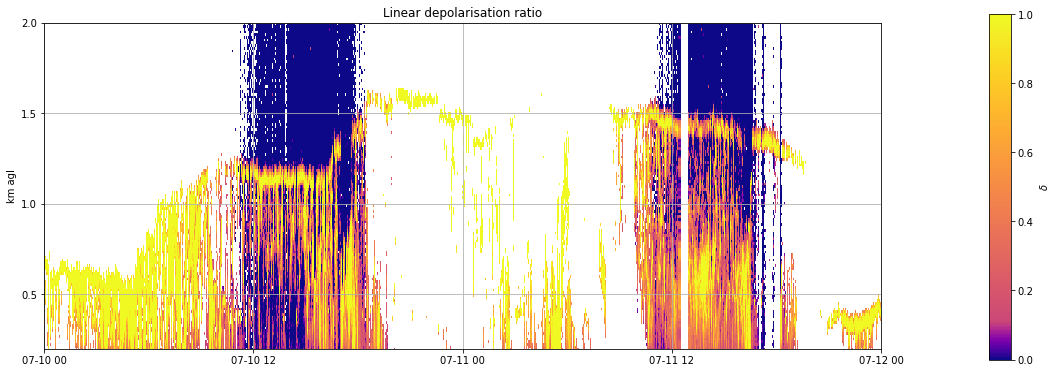

In [113]:
fig = plt.figure(figsize=(15,6))

from matplotlib import colors
colors.TwoSlopeNorm(vmin=-4000., vcenter=0., vmax=10000)
ax3 = fig.add_subplot(111)
d_fig = ax3.pcolormesh(x,lidar_heights[201:],np.transpose(sig1),vmin = 0, vmax = 1,cmap=mpl_cmap)

ax3.xaxis.set_major_formatter(md.DateFormatter('%d%H'))
ax3.xaxis.set_major_locator(md.HourLocator(interval=1))
ax3.set_ylim(0.2,2)
ax3.set_xlim(start,stop)
ax3.set_title('Linear depolarisation ratio')
ax3.set_ylabel('km agl')
myFmt = md.DateFormatter('%m-%d %H')
rule = md.HourLocator(interval=12)
ax3.xaxis.set_major_formatter(myFmt)
ax3.xaxis.set_major_locator(rule)
ax3.grid('on')
plt.locator_params(axis='y', nbins=6)

cbar_ax2 = fig.add_axes([1, 0.1, 0.02, 0.8])
fig.colorbar(d_fig,cax=cbar_ax2,label='$\delta$');

#fig.tight_layout()

In [98]:
#get radar 

# pick date

start_date = dt.datetime(2019,7,10)
stop_date = dt.datetime(2019,7,11)
years = ['2019']
months = ['07']

# Function to making appending data files easier:
flatten = lambda l: [item for sublist in l for item in sublist]

# Load some mergesonde data: 
temp=[]
pres=[]
mixr=[]
times=[]
mergesonde_path = '/gws/nopw/j04/ncas_radar_vol1/heather/mergesonde/merged-mwroe/'
fnames1 = [glob.glob(mergesonde_path + 'smtmergesondeX1.a1.' + dt.datetime.strftime(dat,'%Y%m%d') +'*.cdf')[0] for dat in pd.date_range(start_date,stop_date,freq='1D')]
for fil in fnames1:
    nc = Dataset(fil,'r')
    heights = nc['height'][:] # km asl
    times.append(pd.to_datetime(nc['base_time'][:] + nc['time_offset'][:],origin='unix',unit='s')) # minutely
    pres.append(np.transpose(nc['pres_merge'][:,:])) # Pressure in mb
    temp.append(np.transpose(nc['temp_merge'][:,:])) # Temperature in celcius
    mixr.append(np.transpose(nc['mixr_merge'][:,:])) # Mixing ratio in g/kg

mergesonde_t = pd.DataFrame(index = flatten(times),columns=heights,data=flatten(temp))
mmcr_path = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mmcr/processed/'
all_files = []
f_date_list = pd.date_range(start_date.date(),stop_date.date(),freq='1D')
for date in f_date_list:
    day_of_year = (date.date()).timetuple().tm_yday
    all_files.append(glob.glob(mmcr_path+ 'smtmmcrmomX1.b1.%s*.cdf'%dt.datetime.strftime(date,format='%Y%m%d')))

all_files = flatten(all_files)
all_files.sort()

# Extract data
mmcr_nc = netCDF4.MFDataset(all_files,'r')

# Select radar mode (0,1,2,3) (time)
# For operating mode details see Moran et al., 1998; Mode 4 is good for basic use. 
mode = 3

# Get heights for particular mode
# Range Heights (center of radar sample volume), magl.
# (mode, heights)
Heights = mmcr_nc.variables['heights'][mode,:]
Heights = Heights[Heights.mask == False]

# Get mode/ time
ModeNum = mmcr_nc.variables['ModeNum'][:]    

# Get data quality status and subset for modes
DataQualityStatus = mmcr_nc.variables['DataQualityStatus'][:]
DataQualityStatus = DataQualityStatus[np.where(ModeNum==mode)]

# Get Signal to Noise ratio
# dB, (time, heights)
# Remove signal to noise ratio < -14
SignalToNoiseRatio = mmcr_nc.variables['SignalToNoiseRatio'][:,0:len(Heights)]
SignalToNoiseRatio = SignalToNoiseRatio[np.where(ModeNum==mode)]

# Get reflectivity and subset for mode and heights. Remove bad s2n. 
# Reflectiity, dBZ (time, heights)
Reflectivity = mmcr_nc.variables['Reflectivity'][:,0:len(Heights)]
Reflectivity = Reflectivity[np.where(ModeNum==mode)]
Reflectivity = np.ma.masked_where(SignalToNoiseRatio<-14,Reflectivity)  

# get spectral width 
spec_width = mmcr_nc.variables['SpectralWidth'][:,0:len(Heights)]
spec_width = spec_width[np.where(ModeNum==mode)]
spec_width = np.ma.masked_where(SignalToNoiseRatio<-14,spec_width)

# dopplar velocity 
dv = mmcr_nc.variables['MeanDopplerVelocity'][:,0:len(Heights)]
dv = dv[np.where(ModeNum==mode)]
dv = np.ma.masked_where(SignalToNoiseRatio<-14,dv)

# Get times: 
for i in range(0, len(all_files)):
    mmcr_temp = netCDF4.Dataset(all_files[i],'r')
    # Get mode/ time
    ModeNum = mmcr_temp.variables['ModeNum'][:]    
    base_time = pd.to_datetime(mmcr_temp.variables['base_time'][:],origin='unix',unit='s')
    temp_times = pd.to_datetime(mmcr_temp.variables['time_offset'][:],origin=base_time,unit='s')
    # Subset times for mode
    temp_times = temp_times[np.where(ModeNum==mode)]        
    if i==0:
        all_times = temp_times
    else:
        all_times = np.append(all_times,temp_times)


In [8]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


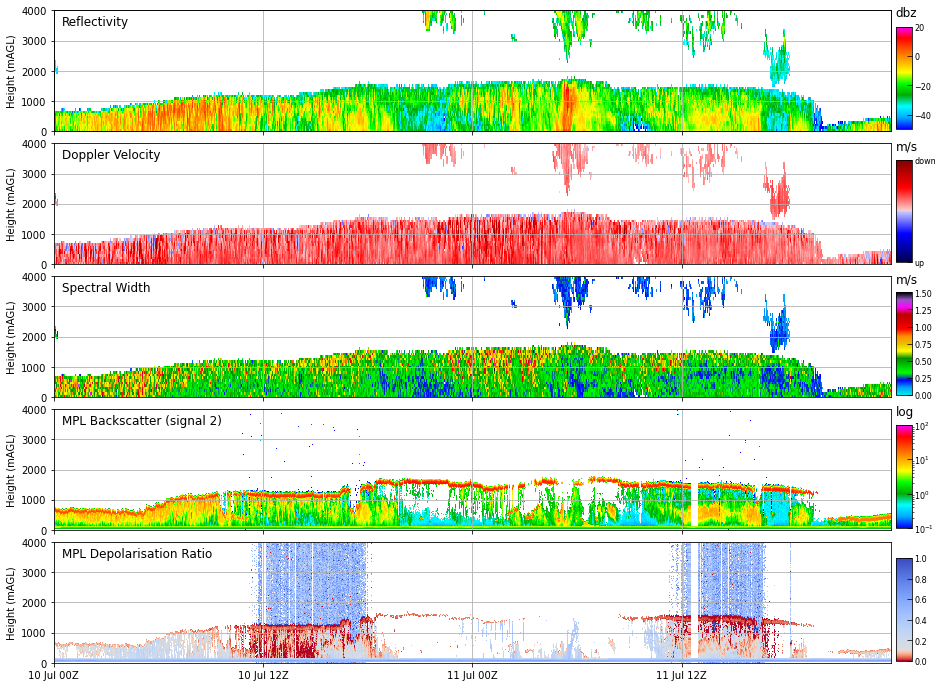

In [117]:
#plt everything 

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(511)
ax1.set_xlim(start_date,stop_date)
ax1.set_xlim(mergesonde_t.index[0],mergesonde_t.index[-1])
rf = ax1.pcolormesh(all_times,Heights,np.transpose(Reflectivity),cmap = 'pyart_RefDiff', vmin=-50, vmax=20) 
ax1.set_ylabel('Height (mAGL)')
ax1.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=12))
ax1.set_ylim(0,4000)
ax1.grid('on')
ax1.set_title('Reflectivity',y=1.0, pad=-15,x = 0.01, ha = 'left')
ax1.set_xticklabels([])
cax = inset_axes(ax1, width="2%", height="85%", loc='lower left',
                   bbox_to_anchor=(1.0,-0.025,1,1), bbox_transform=ax1.transAxes)
cbar = fig.colorbar(rf,cax=cax,orientation='vertical')
cbar.ax.tick_params(axis='y', direction='in', labelsize = 8, pad = 2, width = 0.75, length = 5)
cax.set_title('dbz', y = 1.01, x = 0.0, 
                      fontsize = 12, va = 'bottom', ha = 'left')

ax2 = ax1.twinx()
#ax2.plot(all_times,cth_filtered, color = 'k', label='Cloud top height')
ax2.set_ylim(0,4000)
ax2.set_yticks([])
ax2.set_xlabel([])
ax3 = fig.add_subplot(512)
ax3.set_xlim(start_date,stop_date)
ax3.set_xlim(mergesonde_t.index[0],mergesonde_t.index[-1])
interval = np.hstack([np.linspace(0, 0.45), np.linspace(0.55, 1)])
cols = plt.cm.seismic(interval)
cmap_vel = matplotlib.colors.LinearSegmentedColormap.from_list('name', cols)
rf = ax3.pcolormesh(all_times,Heights,np.transpose(dv),cmap = cmap_vel, vmin=-2.7, vmax=2.7) 
ax3.set_ylabel('Height (mAGL)')
ax3.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax3.xaxis.set_major_locator(md.HourLocator(interval=12))
ax3.set_ylim(0,4000)
ax3.grid('on')
ax3.set_xticklabels([])
ax3.set_title('Doppler Velocity',y=1.0, pad=-15,x = 0.01, ha = 'left')
cax = inset_axes(ax3, width="2%", height="85%", loc='lower left',
                   bbox_to_anchor=(1.0,-0.025,1,1), bbox_transform=ax3.transAxes)
cbar = fig.colorbar(rf,cax=cax,orientation='vertical', ticks = [2.7,-2.7])
cbar.ax.tick_params(axis='y', direction='in', labelsize = 8, pad = 2, width = 0.75, length = 5)
cbar.ax.set_yticklabels(['down','up'])
cax.set_title('m/s', y = 1.01, x = 0.0, 
                      fontsize = 12, va = 'bottom', ha = 'left')

ax4 = fig.add_subplot(513)
ax4.set_xlim(start_date,stop_date)
ax4.set_xlim(mergesonde_t.index[0],mergesonde_t.index[-1])
rf = ax4.pcolormesh(all_times,Heights,np.transpose(spec_width),cmap = 'pyart_NWSRef', vmin=0, vmax=1.5) 
ax4.set_ylabel('Height (mAGL)')
ax4.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax4.xaxis.set_major_locator(md.HourLocator(interval=12))
ax4.set_ylim(0,4000)
ax4.grid('on')
ax4.set_xticklabels([])
ax4.set_title('Spectral Width',y=1.0, pad=-15,x = 0.01, ha = 'left')
cax = inset_axes(ax4, width="2%", height="85%", loc='lower left',
                   bbox_to_anchor=(1.0,-0.025,1,1), bbox_transform=ax4.transAxes)
cbar = fig.colorbar(rf,cax=cax,orientation='vertical')
cbar.ax.tick_params(axis='y', direction='in', labelsize = 8, pad = 2, width = 0.75, length = 5)
cax.set_title('m/s', y = 1.01, x = 0.0, 
                      fontsize = 12, va = 'bottom', ha = 'left')

ax5 = fig.add_subplot(515)
ax5.set_xlim(start_date,stop_date)
ax5.set_xlim(mergesonde_t.index[0],mergesonde_t.index[-1])
rf = ax5.pcolormesh(x,lidar_heights[201:]*1000,np.transpose(d),cmap = mpl_cmap, vmin=0, vmax=1) 
ax5.set_ylabel('Height (mAGL)')
ax5.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax5.xaxis.set_major_locator(md.HourLocator(interval=12))
ax5.set_ylim(0,4000)
ax5.grid('on')
ax5.set_title('MPL Depolarisation Ratio',y=1.0, pad=-15,x = 0.01, ha = 'left')
cax = inset_axes(ax5, width="2%", height="85%", loc='lower left',
                   bbox_to_anchor=(1.0,-0.025,1,1), bbox_transform=ax5.transAxes)
cbar = fig.colorbar(rf,cax=cax,orientation='vertical')
cbar.ax.tick_params(axis='y', direction='in', labelsize = 8, pad = 2, width = 0.75, length = 5)
cax.set_title('', y = 1.01, x = 0.0, 
                      fontsize = 12, va = 'bottom', ha = 'left')

ax6 = fig.add_subplot(514)
ax6.set_xlim(start_date,stop_date)
ax6.set_xlim(mergesonde_t.index[0],mergesonde_t.index[-1])
rf = ax6.pcolormesh(x,lidar_heights[201:]*1000,np.transpose(sig2),cmap = 'pyart_RefDiff', norm=colors.LogNorm(vmin=0.1, vmax=100)) 
ax6.set_ylabel('Height (mAGL)')
ax6.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax6.xaxis.set_major_locator(md.HourLocator(interval=12))
ax6.set_ylim(0,4000)
ax6.grid('on')
ax6.set_title('MPL Backscatter (signal 2)',y=1.0, pad=-15,x = 0.01, ha = 'left')
ax6.set_xticklabels([])
cax = inset_axes(ax6, width="2%", height="85%", loc='lower left',
                   bbox_to_anchor=(1.0,-0.025,1,1), bbox_transform=ax6.transAxes)
cbar = fig.colorbar(rf,cax=cax,orientation='vertical')
cbar.ax.tick_params(axis='y', direction='in', labelsize = 8, pad = 2, width = 0.75, length = 5)
cax.set_title('log', y = 1.01, x = 0.0, 
                      fontsize = 12, va = 'bottom', ha = 'left')

plt.subplots_adjust(hspace=0.1)   
